# Setup

### All imports are here

In [1]:
import os
import shutil
import uuid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import librosa
import soundfile as sf
import IPython.display as ipd

### Clean tmp folder to free up space

In [2]:
try:
    shutil.rmtree('tmp')
except:
    pass  
os.makedirs('tmp')

# Functions

In [3]:
def load_dataset(max_files=1, sample_rate=None):
    """
    Returns python list with [num_tracks] numpy array of shape (track_length, 1), track_length may be different for each song.
    """
    dataset = []
    for i, file in enumerate(os.listdir('audio')):
        if i >= max_files:
            break
        data, sample_rate = librosa.load(f'./audio/{file}', sr=sample_rate)
        data = np.expand_dims(data, axis=-1)
        dataset.append(data)
    return dataset, sample_rate

In [4]:
def cut_dataset(dataset, sample_rate, cut_duration=4):
    cut_dataset = []
    cut_length = sample_rate * cut_duration
    for track in dataset:
        for i in range(0, track.shape[0], cut_length):
            cut_dataset.append(track[i:i+cut_length])
        if cut_dataset[-1].shape[0] != cut_length:
            cut_dataset.pop()
    return cut_dataset


In [5]:
# How should we standardize dataset with multiple songs?
# 1. Each song separately? Then we need to store each scaler separately for each song. How will we apply them properly when testing then?
# 2. All dataset at the same time with one scaler? Tedious to flatten / separate songs for scales + may produce weird results if some songs have different amplitute range

# For now this function works with just one song / sample / whatever
def standardize_track(track):
    scaler = StandardScaler()
    track_scaled = scaler.fit_transform(track)
    return track_scaled, scaler

In [6]:
def display_audio_waveform(audio, sample_rate):
    librosa.display.waveshow(audio.reshape(-1), sr=sample_rate)

In [7]:
def restore_audio(audio_scaled, scaler):
  return scaler.inverse_transform(audio_scaled)

In [8]:
def write_audio(filename, audio, sample_rate):
  sf.write(filename, audio, sample_rate, 'PCM_24')

In [9]:
def play_audio(audio, sample_rate):
    filename = f'tmp/{uuid.uuid1()}.wav'
    write_audio(filename, audio, sample_rate)
    ipd.display(ipd.Audio(filename, rate=sample_rate))

In [10]:
def pad_audio(audio, pad):
    pad_for = pad - (audio.shape[0] % pad)
    if pad == pad_for:
        return audio
    return np.expand_dims(np.pad(audio.reshape(-1), (0, pad_for), 'constant', constant_values=(0, 0)), axis=-1)

In [11]:
n_fft = 2048
hop_length = 512

def get_mel_spectogram(audio, sample_rate):
    padded_audio = pad_audio(audio, pad=n_fft).reshape(-1)
    S = librosa.feature.melspectrogram(y=padded_audio, sr=sample_rate, hop_length=hop_length, n_fft=n_fft)
    S = S.reshape(S.shape[:2])
    return S

In [12]:
# For now cuts are always in the middle of spectogram with the same size
def cut_spectogram(S):
    cut_width = 22 # each second is ~44 width units in those spectograms (for n_fft=2048, hop_length=512)
    cut_y_start = S.shape[1] // 2 - cut_width // 2
    cut_x_start = 0
    cut_height = 128 # 128 is the max height (at least for n_fft=2048, hop_length=512)
    S_cut = np.copy(S)
    S_cut[cut_x_start:cut_x_start + cut_height, cut_y_start:cut_y_start + cut_width] = 0
    return S_cut

In [13]:
def show_mel_spectogram(S, sample_rate):
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sample_rate, fmax=8000)
    plt.colorbar(img, format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')

In [14]:
def reconstruct_raw_audio_from_mel_spectogram(S, sample_rate):
    return np.expand_dims(librosa.feature.inverse.mel_to_audio(S, sr=sample_rate, n_fft=n_fft, hop_length=hop_length), axis=-1)

In [15]:
def get_cnn_model(input_shape):
    model = keras.Sequential()

    # model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    # model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.MaxPooling2D((2, 2)))
    # model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.MaxPooling2D((2, 2)))
    # model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.MaxPooling2D((2, 2)))
    # model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.MaxPooling2D((2, 2)))
    # model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.UpSampling2D((2, 2)))
    # model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.UpSampling2D((2, 2)))
    # model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.UpSampling2D((2, 2)))
    # model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    # model.add(keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    # Convolutional layers
    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))

    model.add(keras.layers.Dropout(0.2))

    # Upsampling layers
    model.add(keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.Conv2DTranspose(1, (3, 3), activation='linear', padding='same'))

    return model

# Experiments

In [16]:
ds, sr = load_dataset()
ds[0].shape, sr

((1316019, 1), 22050)

In [17]:
cut_ds = cut_dataset(ds, sr)
len(cut_ds), cut_ds[0].shape

(14, (88200, 1))

In [18]:
spec_ds = np.array([get_mel_spectogram(sample, sr) for sample in cut_ds])
spec_ds.shape

(14, 128, 177)

In [19]:
X = np.array([cut_spectogram(S) for S in spec_ds])
y = np.copy(spec_ds)

X = np.expand_dims(X, axis=-1)
y = np.expand_dims(y, axis=-1)

scaler = StandardScaler()
num_samples, width, height, channels = y.shape
y = np.reshape(y, (num_samples, width * height * channels))
X = np.reshape(X, (num_samples, width * height * channels))
y = scaler.fit_transform(y)
X = scaler.transform(X)
y = np.reshape(y, (num_samples, width, height, channels))
X = np.reshape(X, (num_samples, width, height, channels))

X.shape, y.shape

((14, 128, 177, 1), (14, 128, 177, 1))

In [20]:
cnn_model = get_cnn_model(X.shape[1:])
cnn_model.compile(optimizer='adam', loss='mean_squared_error')
cnn_model.fit(X, y, epochs=50, validation_split=0.2)

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 1.1164 - val_loss: 3.2736
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 3.4495 - val_loss: 0.8740
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.9419 - val_loss: 0.7489
Epoch 4/50
1/1 [==============================] - 4s 4s/step - loss: 0.8034 - val_loss: 0.6256
Epoch 5/50
1/1 [==============================] - 4s 4s/step - loss: 0.6688 - val_loss: 0.5879
Epoch 6/50
1/1 [==============================] - 4s 4s/step - loss: 0.6395 - val_loss: 0.5116
Epoch 7/50
1/1 [==============================] - 4s 4s/step - loss: 0.5274 - val_loss: 0.5270
Epoch 8/50
1/1 [==============================] - 4s 4s/step - loss: 0.5465 - val_loss: 0.4529
Epoch 9/50
1/1 [==============================] - 4s 4s/step - loss: 0.4569 - val_loss: 0.4704
Epoch 10/50
1/1 [==============================] - 4s 4s/step - loss: 0.4908 - val_loss: 0.4350
Epoch 11/50
1/1 [==============================] 

In [21]:
y_pred = cnn_model.predict(X)

1/1 [==============================] - 2s 2s/step


In [22]:
y = np.reshape(y, (num_samples, width * height * channels))
y_pred = np.reshape(y_pred, (num_samples, width * height * channels))
y = scaler.inverse_transform(y)
y_pred = scaler.inverse_transform(y_pred)
y = np.reshape(y, (num_samples, width, height, channels))
y_pred = np.reshape(y_pred, (num_samples, width, height, channels))

In [23]:
y = y.reshape(y.shape[:-1])
y_pred = y_pred.reshape(y_pred.shape[:-1])

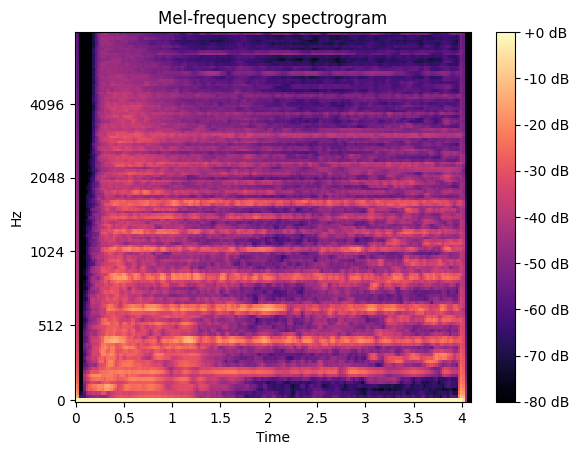

In [24]:
show_mel_spectogram(y[0], sr)

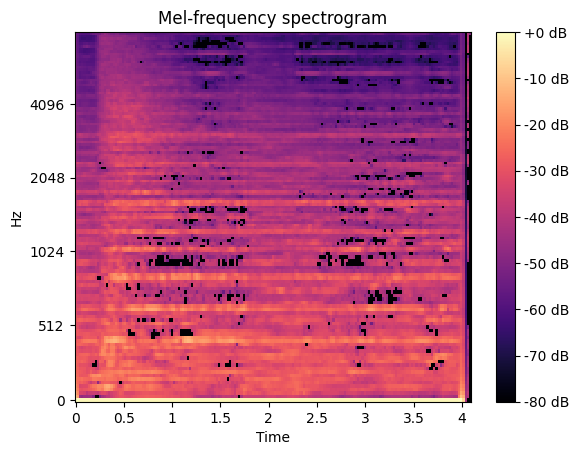

In [25]:
show_mel_spectogram(y_pred[0], sr)

In [26]:
og_audio = reconstruct_raw_audio_from_mel_spectogram(y[0], sr)
cut_audio = reconstruct_raw_audio_from_mel_spectogram(y_pred[0], sr)

In [27]:
play_audio(og_audio, sr)
play_audio(cut_audio, sr)